In [1]:
import numpy as np
#from HH_function import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pickle
from scipy.stats import skewnorm
import multiprocessing
import numpy as np


In [2]:
## Hodgkin-Huxley Model
# Assume that inhibitory and excitatory neurons have the same gating parameters
C_m = 1.0
g_Na = 120.0
g_K = 36.0
g_L = 0.3
E_Na = 50.0
E_K = -77.0
E_L = -54.0

# Channel gating kinetics -> functions of membrane voltage
def alpha_m(V): return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):  return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V): return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):  return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V): return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V): return 0.125 * np.exp(-(V + 65) / 80.0)

# Membrane currents (in uA/cm^2)
# Sodium
def I_Na(V, m, h): return g_Na * m ** 3 * h * (V - E_Na)

# Potassium
def I_K(V, n): return g_K * n ** 4 * (V - E_K)

# Leak
def I_L(V): return g_L * (V - E_L)

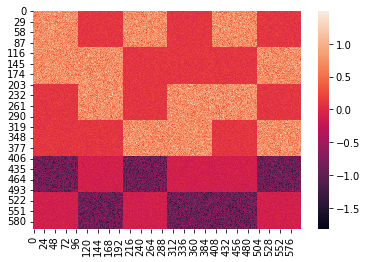

In [3]:
# Populations
N_E = 4
N_I = 2

EI = [[0, 1], [1, 2], [0, 3], [2, 3], [0, 2], [1, 3]]
II = [[4], [5], [4], [5], [5], [4]]

# Neurons
N = 600
ne = 400
ni = 200
n_p = 100 # neurons per population

# Weight matrix
W = np.random.normal(0.1, 0.05, [N, N]) #background activity
W[W<0] = 0
W[ne:N, :] = - W[ne:N, :]

np.fill_diagonal(W, 0) # make diagonal 0

for n in range(N_E + N_I):
    ei = EI[n]
    ii = II[n]
    for j in range(len(ei)):
        W[n_p*ei[j]:n_p*(ei[j]+1), n_p*n:n_p*(n+1)] = 0.9 * np.random.normal(0.8, 0.2, [n_p, n_p])
    for j in range(len(ii)):
        W[n_p*ii[j]:n_p*(ii[j]+1), n_p*n:n_p*(n+1)] = -1.1 * np.random.normal(0.8, 0.2, [n_p, n_p])


# add sparsity
sp = 0 #N + 0
f = 1/4
if np.sum(W==0) < sp:
    W.ravel()[np.random.permutation(N ** 2 - N * ne)[:int(f * (sp - np.sum(W==0)))] + N * ne] = 0
    W.ravel()[np.random.permutation(N ** 2 - N * ni)[:int((1-f) * (sp - np.sum(W==0)))]] = 0

sp = np.sum(W==0) / N ** 2
sns.heatmap(W)
plt.show()

In [4]:
# Resolution of measurement and voltage spike threshold
resolution = 10 # in ms -> resolution 1/10e-3 in Hz
V_thres = 0     # threshold voltage to determine a spike

# Simulation time
T = 100 # ms
dt = 1e-2 # if we want to use higher values we need to scale the gating equations accordingly
T_step = np.linspace(0, T, int(T/dt+1))
time_delay = np.ones(N) * resolution #* (1 + 0.05 * np.random.randn(N))
time_delay = np.array(time_delay/dt, dtype=np.int32) # in ms/dt

# Initialize voltage, spikes, and injected current
V = np.zeros([N, T_step.shape[0]])
spikes_res = np.zeros([N, int(T_step.shape[0]*dt/resolution)])
resolution_window = int(resolution/dt)
I_inj = np.zeros([N, T_step.shape[0] + np.max(time_delay)])

# input resistance and input time decay
Vs = 8
R_e = 0.8
R_i = 0.4
tau_e = 15
tau_i = 10
variables = [Vs, R_e, R_i, tau_e, tau_i]

# Initialize gating variables
m = np.zeros(N)
h = np.zeros(N)
nn = np.zeros(N)

# initial values
r, si = 0, 0
V[:, 0], m[:], h[:], nn[:] = -65, 0.05, 0.6, 0.32

# spike_time, end external stimulation, and select randomly which neuron gets stimulated
spike_time = np.zeros([N])
end_stim = 2
external_input = 0
external_input_t = 0
# plt.plot(Vs / R_e * np.exp(-(T_step) / tau_e / dt))
# plt.show()

In [9]:
for i, t in enumerate(tqdm((T_step[:-1]))):

    # External stimulation
    if t == 0 or np.sum(t-spike_time > 20) == N and (t - external_input_t) > 20:
        idx_rand_stim = np.zeros(N)
        idx_rand_stim[:ne] = np.random.binomial(1, 0.5, ne)
        I_inj[idx_rand_stim.astype(np.bool), i:i + int(end_stim / dt)] = (5 * idx_rand_stim).repeat(int(end_stim / dt)).reshape([N, int(end_stim / dt)])[idx_rand_stim.astype(np.bool), :]
        external_input += 1
        external_input_t = t

    for n in range(N):

        # Spike time memory
        if V[n, i] > V_thres and V[n, i] > V[n, i - 1]:
            spike_time[n] = t

        for j in range(N):
            if V[j, i] > V_thres and V[j, i] > V[j, i - 1]:
                if W[j, n] > 0:
                    I_inj[n, i + time_delay[n]] += W[j, n] * Vs / R_e
                elif W[j, n] < 0:
                    I_inj[n, i + time_delay[n]] += W[j, n] * Vs / R_i
                elif W[j, n] == 0:
                    continue
            elif spike_time[j] != 0:
                if W[j, n] > 0:
                    I_inj[n, i + time_delay[n]] += W[j, n] * Vs / R_e \
                                                   * np.exp(-(t - spike_time[j]) / tau_e)
                elif W[j, n] < 0:
                    I_inj[n, i + time_delay[n]] += W[j, n] * Vs / R_i \
                                                   * np.exp(-(t - spike_time[j]) / tau_i)
                elif W[j, n] == 0:
                    continue
            else:
                continue

        # Constrain input current
        if I_inj[n, i] > 100: I_inj[n, i] = 100
        if I_inj[n, i] < 0: I_inj[n, i] = 0

        # Voltage and gate variables evolution per neuron
        dVdt = (I_inj[n, i] - I_Na(V[n, i], m[n], h[n]) - I_K(V[n, i], nn[n]) - I_L(V[n, i])) / C_m
        dmdt = alpha_m(V[n, i]) * (1.0 - m[n]) - beta_m(V[n, i]) * m[n]
        dhdt = alpha_h(V[n, i]) * (1.0 - h[n]) - beta_h(V[n, i]) * h[n]
        dndt = alpha_n(V[n, i]) * (1.0 - nn[n]) - beta_n(V[n, i]) * nn[n]

        # Update voltage and gate variables
        V[n, i+1] = V[n, i] + dVdt * dt
        m[n] += dmdt * dt
        h[n] += dhdt * dt
        nn[n] += dndt * dt

        if i % resolution_window == 0 and i != 0:
            if n == 0:
                si += 1
            spikes_res[n, si] = 1.0 * (np.sum(V[n, i - resolution_window:i] > V_thres) > 0)


I_inj = I_inj[:, :-np.max(time_delay)-1]

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_28240/1250356354.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I_inj[idx_rand_stim.astype(np.bool), i:i + int(end_stim / dt)] = (5 * idx_rand_stim).repeat(int(end_stim / dt)).reshape([N, int(end_stim / dt)])[idx_rand_stim.astype(np.bool), :]
100%|██████████| 10000/10000 [5:22:16<00:00,  1.93s/it]                          | 347/10000 [01:54<2:10:49,  1.23it/s]


In [ ]:
list1 = [N, W, resolution, T, dt, T_step, spikes_res, I_inj, V, variables]
torch.save(list1, open(r'C:\Users\sebas\RU\intern\data\Results HH\HH_batch_6', 'wb'))

3345.0 1


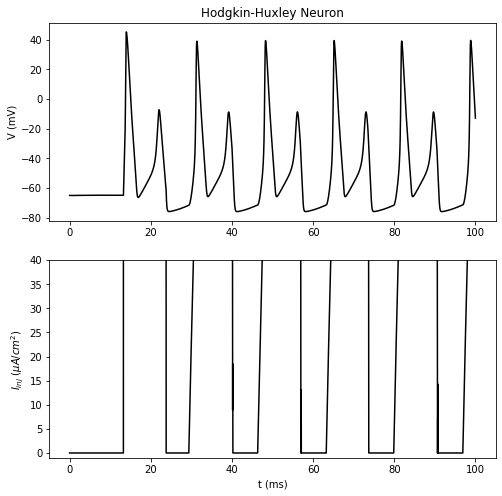

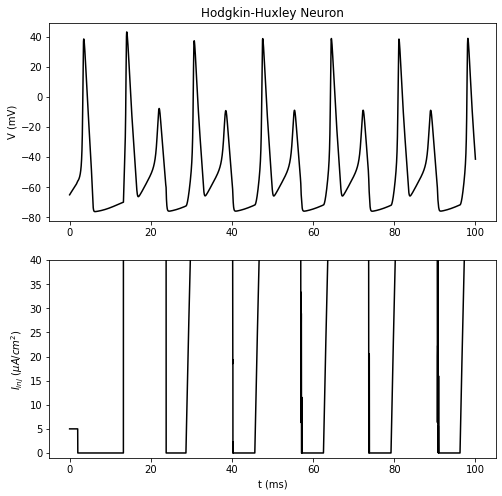

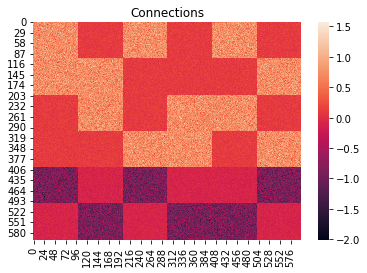

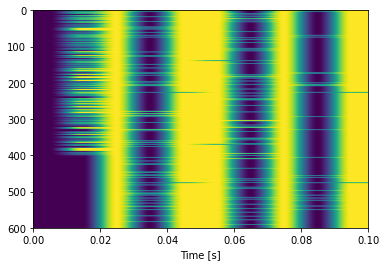

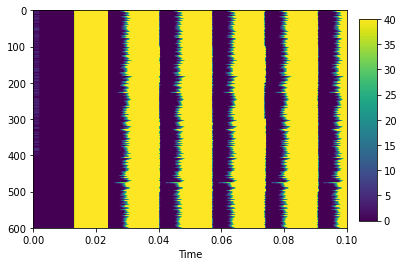

In [10]:
print(np.sum(spikes_res), external_input)

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
L = 10000
ax[0].set_title('Hodgkin-Huxley Neuron')
ax[0].plot(T_step[:L], V[2, :L], 'k')
ax[0].set_ylabel('V (mV)')

ax[1].plot(T_step[:L], I_inj[2, :L], 'k')
ax[1].set_xlabel('t (ms)')
ax[1].set_ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
ax[1].set_ylim(-1, 40)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
L = 10000
ax[0].set_title('Hodgkin-Huxley Neuron')
ax[0].plot(T_step[:L], V[5, :L], 'k')
ax[0].set_ylabel('V (mV)')

ax[1].plot(T_step[:L], I_inj[5, :L], 'k')
ax[1].set_xlabel('t (ms)')
ax[1].set_ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
ax[1].set_ylim(-1, 40)
plt.show()


plt.figure()
sns.heatmap(W)
ax = plt.gca()
plt.title('Connections')
plt.show()

plt.figure()
plt.imshow(spikes_res, extent=[0, T/1000, N, 0], aspect='auto')
ax = plt.gca()
plt.xlabel('Time [s]')
plt.show()

fig = plt.figure()
im = plt.imshow(I_inj, extent=[0, T/1000, N, 0], aspect='auto', vmin=0, vmax=40)
plt.xlabel('Time')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()